# Setup

## Helper Methods

In [1]:
#printing on single line
def printl(msg):
    sys.stdout.write("\r" + str(msg))
    sys.stdout.flush()


#pickler
def save(filepath, obj):
    with open(filepath, 'wb') as file:
        pickle.dump(obj, file, pickle.HIGHEST_PROTOCOL)


#unpickler
def load(filepath):
    return pickle.load(filepath)

## Imports

In [1]:
import sys
import re
import string
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals import joblib

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

import tweepy

## Loading Dataset

In [51]:
%%time
df = pd.read_csv('personality-test.csv')
df['ie'] = df.type
df['ns'] = df.type
df['ft'] = df.type
df['pj'] = df.type

for i, t in enumerate(df.type):
    if 'I' in t:
        df.ie[i] = 'I'
    elif 'E' in t:
        df.ie[i] = 'E'
        
    if 'N' in t:
        df.ns[i] = 'N'
    elif 'S' in t:
        df.ns[i] = 'S'
        
    if 'F' in t:
        df.ft[i] = 'F'
    elif 'T' in t:
        df.ft[i] = 'T'
        
    if 'P' in t:
        df.pj[i] = 'P'
    elif 'J' in t:
        df.pj[i] = 'J'


posts = df.posts.values
yIE = df.ie.values
yNS = df.ns.values
yFT = df.ft.values
yPJ = df.pj.values
y = df.type

CPU times: user 5.41 s, sys: 208 ms, total: 5.62 s
Wall time: 6.28 s


## Preprocessing
NOTE: this phase might take some time to execute due to computationaly expensive operations

In [4]:
#regular expressions for tokenization
regexes = [
    #urls
    #r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',
    
    #html
    #r'<[^>]+>',
    
    #punctuation
    r'(?:(\w+)\'s)',
    
    r'(?:\s(\w+)\.+\s)',
    r'(?:\s(\w+),+\s)',
    r'(?:\s(\w+)\?+\s)',
    r'(?:\s(\w+)!+\s)',
    
    r'(?:\'+(\w+)\'+)',
    r'(?:"+(\w+)"+)',
    r'(?:\[+(\w+)\]+)',
    r'(?:{+(\w+)}+)',
    r'(?:\(+(\w+))',
    r'(?:(\w+)\)+)',

    #words containing numbers & special characters & punctuation
    r'(?:(?:(?:[a-zA-Z])*(?:[0-9!"#$%&\'()*+,\-./:;<=>?@\[\\\]^_`{|}~])+(?:[a-zA-Z])*)+)',
    
    #pure words
    r'([a-zA-Z]+)',
    
    #numbers
    #r'(?:(?:\d+,?)+(?:\.?\d+)?)',

    #emoticons
    #r"""(?:[:=;][oO\-]?[D\)\]\(\]/\\OpP])""",

    #other words
    #r'(?:[\w_]+)',

    #anything else
    #r'(?:\S)'
]

#compiling regular expression
regex = re.compile(r'(?:'+'|'.join(regexes)+')', re.VERBOSE | re.IGNORECASE)


def preprocess(documents):
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    
    #fetching list of stopwords
    punctuation = list(string.punctuation)
    swords = stopwords.words('english') + ['amp'] + ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'january', 'feburary', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december',  'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun',  'jan', 'feb', 'mar', 'apr', 'may', 'jun' 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'tommorow', 'today', 'yesterday'] + ['mr', 'mrs']


    processed_documents = []
    for i,document in enumerate(documents):
        printl('{0}/{1}'.format(i+1, len(documents)))
        
        #tokenization
        tokens = regex.findall(document)

        #skipping useless tokens
        t_regex = re.compile(r"[^a-zA-Z]")
        document = []
        
        for token in tokens:
            token = np.array(token)
            token = np.unique(token[token != ''])
            
            if len(token) > 0:
                token = token[0].lower()
            else:
                continue
                
            if re.search(t_regex, token) == None and token not in swords:
                token = lemmatizer.lemmatize(token)
                document.append(token)
                
        document = ' '.join(document)

        #skipping
        if len(document) > 0:
            processed_documents.append(document)

    print()
    return np.array(processed_documents)

In [44]:
%%time
# posts = preprocess(posts)

8675/8675
CPU times: user 6min 42s, sys: 20.8 s, total: 7min 3s
Wall time: 9min 1s


# Processing

In [53]:
%%time
# creating document frequency matrix
cv = CountVectorizer().fit(posts)
X = cv.transform(posts)

CPU times: user 26.6 s, sys: 696 ms, total: 27.3 s
Wall time: 31.5 s


### Splitting Dataset

In [55]:
# splitting dataset into training and testing dataset
xIETrain, xIETest, yIETrain, yIETest = train_test_split(X, yIE)
xNSTrain, xNSTest, yNSTrain, yNSTest = train_test_split(X, yNS)
xFTTrain, xFTTest, yFTTrain, yFTTest = train_test_split(X, yFT)
xPJTrain, xPJTest, yPJTrain, yPJTest = train_test_split(X, yPJ)
xTrain, xTest, yTrain, yTest = train_test_split(X, y)

# EDA (Exploratory Data Analysis)

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64


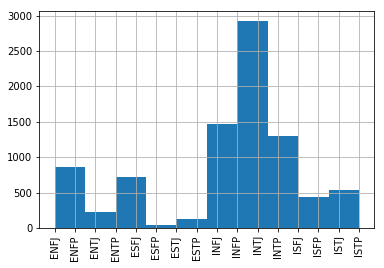

In [8]:
print(df.type.value_counts())
df.type.hist(xrot=90)
plt.show()

In [9]:
print(df.ie.value_counts(), end='\n\n')
print(df.ns.value_counts(), end='\n\n')
print(df.ft.value_counts(), end='\n\n')
print(df.pj.value_counts(), end='\n\n')

I    6676
E    1999
Name: ie, dtype: int64

N    7478
S    1197
Name: ns, dtype: int64

F    4694
T    3981
Name: ft, dtype: int64

P    5241
J    3434
Name: pj, dtype: int64



# Modelling

### Training our Models

In [57]:
%%time
%time model = MultinomialNB().fit(xTrain, yTrain)
%time ieModel = MultinomialNB().fit(xIETrain, yIETrain)
%time nsModel = MultinomialNB().fit(xNSTrain, yNSTrain)
%time ftModel = MultinomialNB().fit(xFTTrain, yFTTrain)
%time pjModel = MultinomialNB().fit(xPJTrain, yPJTrain)

CPU times: user 275 ms, sys: 64.4 ms, total: 339 ms
Wall time: 389 ms
CPU times: user 96.8 ms, sys: 8.91 ms, total: 106 ms
Wall time: 115 ms
CPU times: user 83.4 ms, sys: 10.6 ms, total: 94 ms
Wall time: 101 ms
CPU times: user 93.9 ms, sys: 11 ms, total: 105 ms
Wall time: 124 ms
CPU times: user 97.6 ms, sys: 10.2 ms, total: 108 ms
Wall time: 117 ms
CPU times: user 656 ms, sys: 107 ms, total: 763 ms
Wall time: 860 ms


### Testing our Models

In [58]:
print(model.score(xTest, yTest))
print(ieModel.score(xIETest, yIETest))
print(nsModel.score(xNSTest, yNSTest))
print(ftModel.score(xFTTest, yFTTest))
print(pjModel.score(xPJTest, yPJTest))

0.358690640848
0.785154449055
0.849239280775
0.796680497925
0.716459197787


### Cross Validation

In [81]:
accuracies = []

accuracies.append(cross_val_score(estimator=model, cv=10, X=X, y=y))
accuracies.append(cross_val_score(estimator=ieModel, cv=10, X=X, y=yIE))
accuracies.append(cross_val_score(estimator=nsModel, cv=10, X=X, y=yNS))
accuracies.append(cross_val_score(estimator=ftModel, cv=10, X=X, y=yFT))
accuracies.append(cross_val_score(estimator=pjModel, cv=10, X=X, y=yPJ))

print(accuracies[0].mean())
print(accuracies[0].std(), end='\n\n')
print(accuracies[1].mean())
print(accuracies[1].std(), end='\n\n')
print(accuracies[2].mean())
print(accuracies[2].std(), end='\n\n')
print(accuracies[3].mean())
print(accuracies[3].std(), end='\n\n')
print(accuracies[4].mean())
print(accuracies[4].std(), end='\n\n')

0.376724638516
0.0118203235415

0.783747063909
0.0120576364061

0.834351376084
0.00867280110154

0.800807458079
0.0123263018287

0.727028348914
0.012563989255



### Analysing our Models Results

INFP    468
INFJ    389
INTP    328
INTJ    285
ENTP    176
ENFP    161
ISTP     76
ISFP     74
ENTJ     50
ISTJ     44
ENFJ     43
ISFJ     36
ESTP     18
ESFP      9
ESTJ      7
ESFJ      5
Name: type, dtype: int64

INFP    1390
INFJ     408
INTP     308
INTJ      51
ENFP       5
ENTP       4
ISFP       2
ISTP       1
dtype: int64


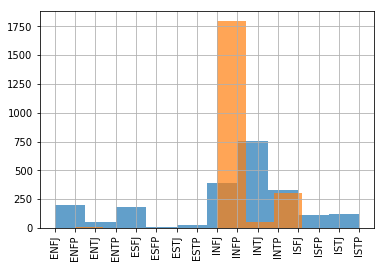

In [60]:
print(pd.Series(yTest).value_counts(), end='\n\n')
print(pd.Series(model.predict(xTest)).value_counts())

pd.Series(yTest).hist(xrot=90, alpha=0.7)
pd.Series(model.predict(xTest)).hist(xrot=90, alpha=0.7)
plt.show()

I    1685
E     484
dtype: int64

I    2051
E     118
dtype: int64


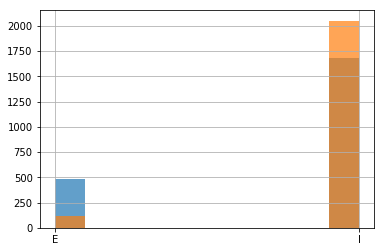

In [61]:
print(pd.Series(yIETest).value_counts(), end='\n\n')
print(pd.Series(ieModel.predict(xIETest)).value_counts())

pd.Series(yIETest).hist(alpha=0.7)
pd.Series(ieModel.predict(xIETest)).hist(alpha=0.7)
plt.show()

N    1874
S     295
dtype: int64

N    2071
S      98
dtype: int64


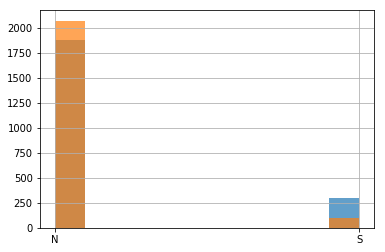

In [62]:
print(pd.Series(yNSTest).value_counts(), end='\n\n')
print(pd.Series(nsModel.predict(xNSTest)).value_counts())

pd.Series(yNSTest).hist(alpha=0.7)
pd.Series(nsModel.predict(xNSTest)).hist(alpha=0.7)
plt.show()

F    1194
T     975
dtype: int64

F    1283
T     886
dtype: int64


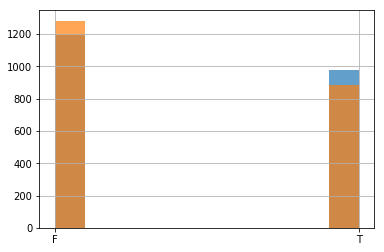

In [63]:
print(pd.Series(yFTTest).value_counts(), end='\n\n')
print(pd.Series(ftModel.predict(xFTTest)).value_counts())

pd.Series(yFTTest).hist(alpha=0.7)
pd.Series(ftModel.predict(xFTTest)).hist(alpha=0.7)
plt.show()

P    1311
J     858
dtype: int64

P    1614
J     555
dtype: int64


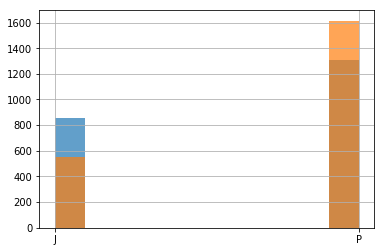

In [64]:
print(pd.Series(yPJTest).value_counts(), end='\n\n')
print(pd.Series(pjModel.predict(xPJTest)).value_counts())

pd.Series(yPJTest).hist(alpha=0.7)
pd.Series(pjModel.predict(xPJTest)).hist(alpha=0.7)
plt.show()

### Pickling our Models

In [82]:
models = {
    'models': [model, ieModel, nsModel, ftModel, pjModel],
    'accuracies': accuracies,
    'usable': [False, False, False, True, True]
}
joblib.dump(models, 'models.pkl')

['models.pkl']

# Twitter

In [2]:
CONSUMER_KEY        = os.environ['TWITTER_CONSUMER_KEY']
CONSUMER_SECRET     = os.environ['TWITTER_CONSUMER_SECRET']
ACCESS_TOKEN        = os.environ['TWITTER_ACCESS_TOKEN']
ACCESS_TOKEN_SECRET = os.environ['TWITTER_ACCESS_TOKEN_SECRET']

AUTH = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
AUTH.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

api = tweepy.API(AUTH)

# Bootstrapping

### Fetching Tweets

In [65]:
#getting user tweets
tweets = api.user_timeline('narendramodi', count=200)
tweets = [tweet.text for tweet in tweets]

### Procsssing Tweets

In [69]:
document = cv.transform([' '.join(tweets)])

### Predicting MBTI Personality

In [80]:
print(ieModel.predict(document))
print(nsModel.predict(document))
print(ftModel.predict(document))
print(pjModel.predict(document))

['I']
['N']
['T']
['J']
